## Quantum classifier

Trhough `PennyLane` library we can construct a circuit which serves as model to classify our created dataset, it substitutes the classical model  construct with `arctan`, which has no power to differentiate the two subgruops in the plane. 

In [19]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

**Create datset**

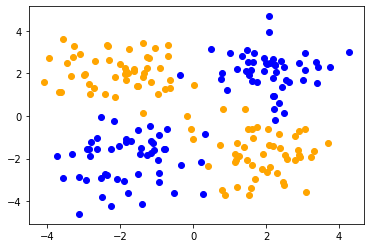

In [20]:
n_samples = 200
A = np.array([[np.random.normal(loc=-2), np.random.normal(loc=2)] for i in range(n_samples//4)])
B = np.array([[np.random.normal(loc=2), np.random.normal(loc=-2)] for i in range(n_samples//4)])
C = np.array([[np.random.normal(loc=2), np.random.normal(loc=2)] for i in range(n_samples//4)])
D = np.array([[np.random.normal(loc=-2), np.random.normal(loc=-2)] for i in range(n_samples//4)])

plt.scatter(A[:,0], A[:,1], color = 'orange')
plt.scatter(B[:,0], B[:,1], color = 'orange')
plt.scatter(C[:,0], C[:,1], color = 'blue')
plt.scatter(D[:,0], D[:,1], color = 'blue')

plt.show()

In [21]:
# Assigning value -1 to yellow points and 1 to blue points
feature = np.concatenate([A,B,C,D], axis = 0)
label = np.concatenate([-np.ones(n_samples//2), np.ones(n_samples//2)], axis = 0)
data = list(zip(feature, label))

**Embedding dataset into circuit**

In [32]:
# Embedding data into angles
# We have 4 defined 4 parameters:
    # 2 for varying the location and amplitude of planes.
    # 2 for varying periods of wavefunctions.
dev = qml.device('default.qubit', wires = 2)
@qml.qnode(dev)
def model(x,w): 
    
    qml.RX(x[0]*w[2], wires = 0)
    qml.RX(x[1]*w[3], wires = 1)
    
    qml.RX(w[0], wires = 0)
    qml.RX(w[1], wires = 1)
    
    qml.CNOT(wires = [1,0])
    
    return qml.expval(qml.PauliZ(wires = 0))

In [33]:

def z_func(x,w):
    return model(x,w)

limit = np.pi
x = np.arange(-limit, limit, 0.2)
y = np.arange(-limit, limit, 0.2)

#Calculating the output and storing it in the array Z

def plot(f):
    Z = np.zeros([len(x), len(y)])
    for ind, i in enumerate(x):
        for ind2, j in enumerate(y):
            Z[ind, ind2] = f([i,j], w)
    
    im = plt.imshow(Z, extent = (-limit, limit, -limit, limit), interpolation='bilinear')
    
    plt.scatter(A[:,0], A[:,1], color = 'orange')
    plt.scatter(B[:,0], B[:,1], color = 'orange')
    plt.scatter(C[:,0], C[:,1], color = 'blue')
    plt.scatter(D[:,0], D[:,1], color = 'blue')
    
    plt.axis((-limit, limit, -limit, limit))
    plt.colorbar(im)
    
    plt.show()

**Defining loss function**

In [34]:
# Defining the loss function

def average_loss(w, data):
    losses = 0
    for x,y in data: 
        losses += (model(x,w) - y)**2
    return losses/len(data)

In [35]:
gradient_fn_w = qml.grad(average_loss, argnum = 0)

**Training model and plotting results**

epoch 0 loss 1.1041395302465038


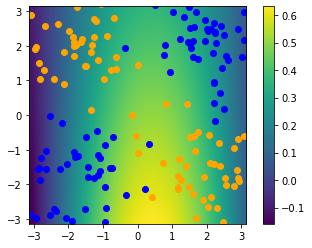

epoch 20 loss 0.3077779797819837


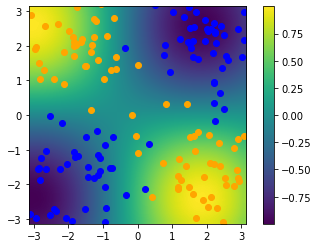

epoch 40 loss 0.22194880000582745


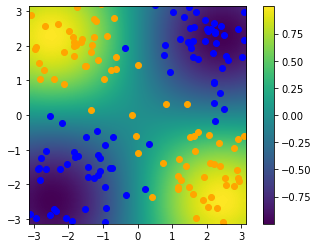

epoch 60 loss 0.21797339129704116


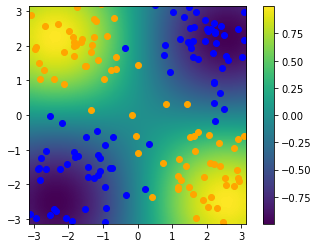

epoch 80 loss 0.21778764271703552


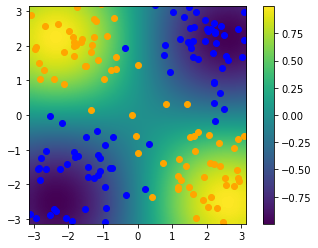

epoch 100 loss 0.21777884338834522


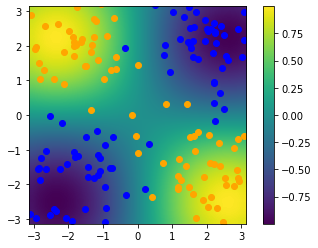

In [36]:
#Training the model 
from IPython.display import clear_output
w = np.array([-1,-0.2,0.,0.5], requires_grad = True)

#Learning rate
lr = 0.1
for epoch in range(101):
    w = w - lr*gradient_fn_w(w, data)
    if epoch % 20 == 0:
        print('epoch', epoch, 'loss', average_loss(w, data))
        plot(model)